# Machine Learning and Deep Learning in Psychiatric Diagnoses using fMRI

## **Motivation and Objectives**

-The objective of this project is to predict whether fMRI data can be used to discriminate between healthy and neuropsychiatrically abnormal subjects. Based on the result of this project, I would like to take one step further to create deep learning neural network model from fMRI data to assist in neuropsychiatric diagnoses
-This is a challenging problem, hence my realistic goal is not to solve the problem but to determine an easy protocol to process fMRI data within my computing power. Additionally, how to implement machine learning and deep learning models on processed fMRI data.
-It is expected that the modeling accuracy should be very low (otherwise everybody could have done it already)

## **1. Data Source**


- Dataset was originated from Gorgolewski KJ, Durnez J and Poldrack RA. Preprocessed Consortium for Neuropsychiatric Phenomics dataset. F1000Research 2017, 6:1262
https://doi.org/10.12688/f1000research.11964.2
- Dataset includes neuroimaging as well as phenotypic information for 272 participants from Consortium for Neuropsychiatric Phenomics.The subject population consists of healthy controls (130 subjects), as well as participants with diagnoses of adult ADHD (43 subjects), bipolar disorder (49 subjects) and schizophrenia (50 subjects).
- There are big difference between the size of each group. Therefore, to make the training process more reliable, I grouped ADHD,bipolar ans schizophrenia groups into 1 and called it 'unhealthy group' altogether.
- The following fMRI protocols were used to obtain this dataset:
1. A resting state fMRI session of 304 seconds
2. Balloon analog risk task (bart)
3. Paired associate memory task (pamenc)
4. Spatial working memory task (scap)
5. Stop signal task 
6. Task-switching task
7. Breath holding task (bht)

Due to the scope of this project, I only chose 1 set of fMRI protocol to implement machine learning and deep learning models. Balloon analog risk task (BART) was chosen as it is performed in many other studies and it would be easy to obtain more online data in the future. In this experiment, participants were allowed to pump a series of virtual balloons. Experimental balloons (green) resulted either in an explosion or in a successful pump (no explosion and 5 points). Control (white) balloons did not result in points nor exploded. Participants could choose not to pump but to cash out and start with a new balloon. Many studies have shown that individuals with psychiatric diseases are more likely to engage in high risk behaviours. I expect that there are differences between healthy and unhealthy groups in this experiment. 

To simplify and reduce the amount of time needed for preprocessing the data, I used normalized data derived from fMRIprep which were published online by the authors.
fMRI data were obtained after the following preprocessing steps:
1. Motion corrected using ANTs N4BiasFieldCorrection v2.1.0
2. Skullstripped using antsBrainExtraction.sh v2.1.0 (using OASIS template)
3. Coregistered to skullstripped ICBM 152 Nonlinear Asymmetrical template version 2009c9 using symmetric image normalization method (SyN) nonlinear transformation with affine initialization implemented in ANTs v2.1.0


## **2. Workflow**

The outline of this project is as follows:

1. To keep the correct order of diagnosis for each subject, file links of BART and REST were loaded to pandas dataframe and remove subjects with unavailable (nan) data
2. fMRI data were loaded using Nilearn's Nibabel
3. 4D fMRI data were converted into 2D data using Nilearn's MultiNiftiMasker function
4. Dimensionality reduction needed for machine learning models was performed using PCA to obtain data with shape (n samples,n features) for both BART and REST
5. BART numpy array was substracted with baseline REST numpy array to obtain a numpy array that represents real BART effect 
6. The resulting processed data were fed into machine learning and deep learning models
7. For machine learning prediction, Scikit-learn models were used.Hyperparameter tuning and model stacking were also performed in order to improve prediction accuracy
8. For deep learning prediction, Keras's sequential model was used. To improve accuracy, hyperparameter tuning was performed with Keras tuner module.

## **3. Results**

### 1. Load file links of BART and REST to pandas dataframe and remove subjects with unavailable (nan) data

In [1]:
# Load data information onto pandas dataframe
import pandas as pd
participants=pd.read_table("D:/participants.tsv",header=0)
participants

,participant_id,diagnosis,age,gender,bart,bht,dwi,pamenc,pamret,rest,scap,stopsignal,T1w,taskswitch,ScannerSerialNumber,ghost_NoGhost
0,sub-10159,CONTROL,30,F,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost
1,sub-10171,CONTROL,24,M,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost
2,sub-10189,CONTROL,49,M,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost
3,sub-10193,CONTROL,40,M,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,35343.0,No_ghost
4,sub-10206,CONTROL,21,M,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,sub-70079,ADHD,21,M,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,35426.0,No_ghost
268,sub-70080,ADHD,48,M,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,35426.0,No_ghost
269,sub-70081,ADHD,50,M,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,35426.0,No_ghost
270,sub-70083,ADHD,46,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,35426.0,No_ghost


In [2]:
#Define function to load file links to a list
data_folder='D:/data/ds000030_R1.0.5/ds000030_R1.0.5/derivatives/fmriprep/'
subject_list=participants['participant_id']
import os,shutil
def load_links_to_list(file_key,mask_key,fmri_temp,fmri_id,fmri_mask_temp,fmri_mask,fmri_load):
    for dirpath,sf,filenames in os.walk(data_folder):
        for filename in filenames:
            if file_key in filename:
                fmri_temp.append(os.path.join(dirpath,filename))
            elif mask_key in filename:
                fmri_mask_temp.append(os.path.join(dirpath,filename))
    for i in fmri_temp:
        for k in fmri_mask_temp:
            for j in subject_list:
                if (j in i) and (j in k):
                    fmri_id.append(j)
                    fmri_load.append(i)
                    fmri_mask.append(k)
    return fmri_temp,fmri_id,fmri_load,fmri_mask,fmri_mask_temp

In [3]:
#load BART file links to a list
bart_fmri=[]
bart_file=[]
bart_id=[]
bart_mask=[]
bart_mask_temp=[]
load_links_to_list(file_key='task-bart_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
                   mask_key='task-bart_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz', 
                   fmri_temp=bart_fmri,fmri_id=bart_id,
                   fmri_mask_temp=bart_mask_temp,
                   fmri_mask=bart_mask,
                   fmri_load=bart_file)
#load bart list to df
bart_s=pd.Series(bart_file,name='bart_file')
bart_ss=pd.Series(bart_id,name='subject_id')
bart_sss=pd.Series(bart_mask,name='bart_mask')
data_bart={"subject_id":bart_ss,'bart_file':bart_s,'bart_mask':bart_sss}
bart_df=pd.concat(data_bart,axis=1)
bart_df  

,subject_id,bart_file,bart_mask
0,sub-10159,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
1,sub-10171,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
2,sub-10189,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
3,sub-10193,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
4,sub-10206,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
...,...,...,...
257,sub-70079,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
258,sub-70080,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
259,sub-70081,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
260,sub-70083,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...


In [4]:
#Load REST file links to a list
rest_fmri=[]
rest_file=[]
rest_mask=[]
rest_id=[]
rest_mask_temp=[]
load_links_to_list(file_key='task-rest_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
                   mask_key='task-rest_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz', 
                   fmri_temp=rest_fmri,fmri_id=rest_id,
                   fmri_mask_temp=rest_mask_temp,
                   fmri_mask=rest_mask,
                   fmri_load=rest_file)
#load bart list to df
rest_s=pd.Series(rest_file,name='rest_file')
rest_ss=pd.Series(rest_id,name='subject_id')
rest_sss=pd.Series(rest_mask,name='rest_mask')
data_rest={"subject_id":rest_ss,'rest_file':rest_s,'rest_mask':rest_sss}
rest_df=pd.concat(data_rest,axis=1)
rest_df 


,subject_id,rest_file,rest_mask
0,sub-10159,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
1,sub-10171,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
2,sub-10189,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
3,sub-10206,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
4,sub-10217,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
...,...,...,...
256,sub-70079,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
257,sub-70080,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
258,sub-70081,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
259,sub-70083,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...


In [5]:
#Merge 2 dfs into 1 and eliminate 'nan' cells
participants['subject_id']=participants['participant_id']
df=participants.merge(rest_df,how='outer')
df=df[['subject_id','diagnosis','rest_file','rest_mask']]
df=df.dropna(axis=0,how='any')
df=df.merge(bart_df,how='outer')
df=df[['subject_id','diagnosis','rest_file','rest_mask','bart_file','bart_mask']]
df=df.dropna(axis=0,how='any')
df

,subject_id,diagnosis,rest_file,rest_mask,bart_file,bart_mask
0,sub-10159,CONTROL,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
1,sub-10171,CONTROL,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
2,sub-10189,CONTROL,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
3,sub-10206,CONTROL,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
4,sub-10217,CONTROL,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
...,...,...,...,...,...,...
256,sub-70079,ADHD,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
257,sub-70080,ADHD,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
258,sub-70081,ADHD,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...
259,sub-70083,ADHD,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...


In [6]:
#Convert data type of 'diagnosis' column into int datatype
df['diagnosis']=df['diagnosis'].replace({'CONTROL':0,'SCHZ':1,'BIPOLAR':1,'ADHD':1})

In [7]:
#save dataframe 
pd.DataFrame.to_csv(df,'full_df_20210213.csv')

### 2. Load data with Nibabel and convert data to 2D numpy arrays with MultiNiftiMasker from Nilearn

In [8]:
#Load bart data as numpy arrays onto dataframes but only take the first 100 slices
!pip install nilearn
!pip install nibabel
from nilearn.image import index_img
import nibabel as nib
import numpy as np
bart_data=[]
bart_data_id=[]
for i in df['bart_file']:
    for j in df['subject_id']:
        if j in i:
            bart_data.append(index_img(nib.load(i),slice(0,100)))
bart_load2=[]
for i in bart_data:
    bart_load2.append(i.get_fdata())
   

In [9]:
#Create Niftimasks for all data points in df['bart_file'] then reduce dimension with pca
import numpy as np
from nilearn.input_data import MultiNiftiMasker,NiftiMasker
from nilearn.image import index_img
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import accuracy_score,f1_score
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from dask.distributed import Client
import joblib
pca=PCA(n_components=1)
bart_masked=[]
bart_masked_pca=[]
bart_masked_id=[]
for i in df['bart_file']:
    for j in df['bart_mask']:
         for k in df['subject_id']:
            if (k in j) and (k in i):
                bart_masker=MultiNiftiMasker(mask_img=j,
                                              smoothing_fwhm=4,
                                              standardize=True,
                                              detrend=True,
                                              memory='D:/cache',
                                              memory_level=1)
                x=bart_masker.fit_transform(index_img(i,slice(0,100)))
                bart_masked_pca.append(pca.fit_transform(x))
                bart_masked_id.append(k)
#Load bart_masked_pca onto dataframe
bart_masked_pca_1=pd.Series(bart_masked_pca,name='bart_masked_pca')
bart_masked_id_1=pd.Series(bart_masked_id,name='subject_id')
data_masked_pca={'bart_masked_pca':bart_masked_pca_1,'subject_id':bart_masked_id_1}
df_masked_pca=pd.concat(data_masked_pca,axis=1)
df=df.merge(df_masked_pca,how='outer')


In [10]:
#Save bart numpy array 
bart_masked_pca=np.asarray(bart_masked_pca)
bart_masked_pca=bart_masked_pca.reshape(len(df['diagnosis']),100)
np.save('bart_masked_pca_full_20210213.npy',bart_masked_pca)

In [11]:
#Load rest data as numpy arrays onto dataframes but only take the first 100 slices
from nilearn.image import index_img
import nibabel as nib
import numpy as np
rest_data=[]
rest_data_id=[]
for i in df['rest_file']:
    for j in df['subject_id']:
        if j in i:
            rest_data.append(index_img(nib.load(i),slice(0,100)))
rest_load2=[]
for i in rest_data:
    rest_load2.append(i.get_fdata())

In [12]:
#Create Niftimasks for all data points in df['rest_file'] then reduce dimension with pca
import numpy as np
from nilearn.input_data import MultiNiftiMasker,NiftiMasker
from nilearn.image import index_img
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import accuracy_score,f1_score
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from dask.distributed import Client
import joblib
pca=PCA(n_components=1)
rest_masked=[]
rest_masked_pca=[]
rest_masked_id=[]
for i in df['rest_file']:
    for j in df['rest_mask']:
         for k in df['subject_id']:
            if (k in j) and (k in i):
                rest_masker=MultiNiftiMasker(mask_img=j,
                                              smoothing_fwhm=4,
                                              standardize=True,
                                              detrend=True,
                                              memory='D:/cache',
                                              memory_level=1)
                x=rest_masker.fit_transform(index_img(i,slice(0,100)))
                rest_masked_pca.append(pca.fit_transform(x))
                rest_masked_id.append(k)
#Load rest_masked_pca onto dataframe
rest_masked_pca_1=pd.Series(rest_masked_pca,name='rest_masked_pca')
rest_masked_id_1=pd.Series(rest_masked_id,name='subject_id')
rest_data_masked_pca={'rest_masked_pca':rest_masked_pca_1,'subject_id':rest_masked_id_1}
df_rest_masked_pca=pd.concat(rest_data_masked_pca,axis=1)
df=df.merge(df_rest_masked_pca,how='outer')
df

,subject_id,diagnosis,rest_file,rest_mask,bart_file,bart_mask,bart_masked_pca,rest_masked_pca
0,sub-10159,0,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,"[[-119.2918], [-47.42849], [-47.004158], [-46....","[[5.5501328], [-24.35311], [25.47392], [54.364..."
1,sub-10171,0,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,"[[-10.095797], [-89.482895], [-83.825516], [-1...","[[7.2441974], [2.2628493], [5.188112], [17.181..."
2,sub-10189,0,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,"[[78.70989], [227.72089], [285.4811], [324.921...","[[-106.57007], [109.13381], [16.144218], [-107..."
3,sub-10206,0,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,"[[199.81163], [218.78578], [251.33499], [255.6...","[[44.442364], [64.48431], [20.470474], [-32.00..."
4,sub-10217,0,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,"[[-101.402954], [-83.988365], [-14.08974], [-1...","[[110.13684], [150.73079], [144.91249], [90.12..."
...,...,...,...,...,...,...,...,...
253,sub-70079,1,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,"[[45.18904], [87.68996], [80.10079], [1053.710...","[[275.1737], [393.63715], [286.47617], [158.76..."
254,sub-70080,1,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,"[[309.9218], [232.34848], [118.04234], [-37.97...","[[167.95813], [93.60904], [-13.383028], [8.734..."
255,sub-70081,1,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,"[[-41.115784], [-95.1266], [-161.8031], [-76.9...","[[74.10456], [20.79052], [-8.9845705], [14.760..."
256,sub-70083,1,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,D:/data/ds000030_R1.0.5/ds000030_R1.0.5/deriva...,"[[-33.41434], [79.47234], [-104.957924], [-48....","[[44.281647], [-25.293], [68.3606], [-84.82778..."


In [13]:
#Save rest numpy array 
rest_masked_pca=np.asarray(rest_masked_pca)
rest_masked_pca=rest_masked_pca.reshape(len(df['diagnosis']),100)
np.save('rest_masked_pca_full_20210213.npy',rest_masked_pca)

In [14]:
#Examine correlation between BART and REST arrays
print (bart_masked_pca.shape,rest_masked_pca.shape)

(258, 100) (258, 100)


In [15]:
#Hstack bart_masked_pca and rest_masked_pca arrays to create 1D array for correlation computation
bart_stack=np.hstack(bart_masked_pca)
rest_stack=np.hstack(rest_masked_pca)
print (bart_stack.shape,rest_stack.shape)

(25800,) (25800,)


In [16]:
corr=np.corrcoef(bart_stack,rest_stack)
corr

array([[1.        , 0.01960475],
       [0.01960475, 1.        ]])

Low Pearson correlation indicates that there's almost no correlation between BART and REST data. It is safe to say that I can perform meaningful predictions using BART data

### 3. Substract BART array with REST array to take into account baseline level

In [17]:
#substract REST from BART
b_r_pca=bart_masked_pca-rest_masked_pca
np.save('bart-rest_masked_pca_full_20210213.npy',b_r_pca)

In [18]:
#convert label column to numpy array
diagnosis=np.asarray(df['diagnosis'])
#check for shapes of feature column and label column
print ('Shape of feature:{} and label :{}'.format(b_r_pca.shape,df['diagnosis'].shape))
pd.unique(df['diagnosis'])

Shape of feature:(258, 100) and label :(258,)


array([0, 1], dtype=int64)

### 4. Create train,test datasets

In [19]:
from sklearn.model_selection import RepeatedStratifiedKFold,train_test_split
from sklearn import preprocessing
X_train,X_test,y_train,y_test= train_test_split(b_r_pca,diagnosis,stratify=diagnosis,test_size=0.4,random_state=42)
print (y_train,y_test)

[0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0
 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0
 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0
 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 0
 0 1 1 1 0 1] [1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0
 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 1
 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1 0]


### 5. Prediction with a tuned machine learning model

In [20]:

from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from dask.distributed import Client
from sklearn.svm import SVC
import joblib
#Hyperparameter tuning for SVC model
client = Client(processes=False)             

param_space = {
    'kernel':('poly','rbf','sigmoid'),
    'C': np.logspace(-4, 4,10),
    'gamma': np.logspace(-4, 4,10),
    'tol': np.logspace(-4,4,5),
    'class_weight': [None, 'balanced']
}

model = SVC(cache_size=8000)

b_r_search = GridSearchCV(model, param_space,cv=5,scoring='accuracy',verbose=10,n_jobs=5)
with joblib.parallel_backend('loky'):
    b_r_search.fit(b_r_pca,diagnosis)                 
print ("Best params: {} \n Best score: {}".format(b_r_search.best_params_,b_r_search.best_score_))

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1715s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0170s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  45 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1630s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  79 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0520s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 151 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Batch computation to

              precision    recall  f1-score   support

           0       0.47      0.31      0.37        49
           1       0.53      0.69      0.60        55

    accuracy                           0.51       104
   macro avg       0.50      0.50      0.48       104
weighted avg       0.50      0.51      0.49       104



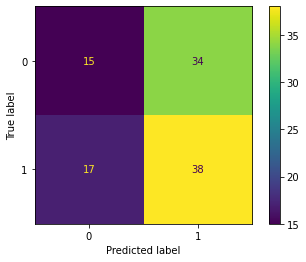

In [21]:
from sklearn.metrics import accuracy_score,f1_score,classification_report,plot_confusion_matrix
import matplotlib.pyplot as plt 
#use best parameters for prediction
b_r_model =SVC()
b_r_model.set_params(**b_r_search.best_params_)
b_r_fit=b_r_model.fit(X_train,y_train)
b_r_pred=b_r_fit.predict(X_test)
b_r_report=classification_report(y_test, b_r_pred,labels=[0,1])
plot_confusion_matrix(b_r_model,X_test,y_test)
print (b_r_report)
plt.show()


In [22]:
#save best params
joblib.dump(b_r_search.best_params_,'b_r_randCV_svc_params_20210210.pkl')
import gc
gc.collect()

4161

### 6. Prediction by stacked and tuned machine learning models

In [23]:
# compare standalone models for binary classification
!pip install xgboost   
from numpy import mean
import numpy as np
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier
from matplotlib import pyplot
from sklearn.ensemble import StackingClassifier,RandomForestClassifier     
import random

In [28]:
# get a list of models to evaluate
grid_KNeighborsClassifier={ # KNN
        'n_neighbors':[5,6,7,8,9,10],
        'leaf_size':[1,2,3,5],
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree','kd_tree','brute']
        
    }

grid_SVC={ # SVC
        'kernel':('poly','rbf','sigmoid'),
        'C': np.logspace(-4, 4, 10),
        'gamma': np.logspace(-4, 4, 10),
        'tol': np.logspace(-4,4,5),
        'class_weight': [None, 'balanced']
    }
grid_XGBClassifier= { # XGBoost
        'n_estimators': [400, 700, 1000],
        'colsample_bytree': [0.4, 0.8],
        'max_depth': [10,20,30],
        'reg_alpha': [0.8, 1, 1.2],
        'reg_lambda': [0.8, 1, 1.2]
        
    }
grid_RandomForestClassifier={ # Random Forest
        'max_depth':[3, 5, 10, 13],
        'n_estimators':[100, 200, 400, 600, 900],
        'max_features':[2, 4, 6, 8, 10],
        'criterion':['gini','entropy'],
        'min_samples_leaf':[1,2,3],
        'min_samples_split':[3,4,5,6,7], 
        'random_state':[42]
        
    }

In [29]:
# evaluate a given model using cross-validation

def evaluate_model(model, X, y,param_space):
    search=GridSearchCV(model, param_space,scoring='accuracy',verbose=10,n_jobs=5)
    search.fit(X,y)
    print ('Best score: {}\n Best params: {}'.format(search.best_score_,search.best_params_))
    return search.best_params_
def get_models():
    models = dict()
    models['knn'] = KNeighborsClassifier()
    models['svm'] = SVC()
    models['xgb'] = XGBClassifier()
    models['rfc']= RandomForestClassifier()
    return models
def get_grids():
    grids=dict()
    grids['knn'] = grid_KNeighborsClassifier
    grids['svm'] = grid_SVC
    grids['xgb'] = grid_XGBClassifier
    grids['rfc']=grid_RandomForestClassifier
    return grids

In [30]:
returns=[]
names=[]
models=get_models()
grids=get_grids()
knn=KNeighborsClassifier()
svm = SVC(cache_size=8000)
xgb=XGBClassifier()
rfc=RandomForestClassifier()
        
with joblib.parallel_backend('loky'):
    #evaluate SVC and save best params
    z=evaluate_model(svm,X_train,y_train,grid_SVC) 
    joblib.dump(z,'b_r_svc_best_params_20210210.pkl')
    #evaluate XGBoost and save best params
    p=evaluate_model(xgb,X_train,y_train,grid_XGBClassifier) 
    joblib.dump(p,'b_r_xgb_best_params_20210210.pkl')
    #evaluate RandomForestClassifier and save best params
    q=evaluate_model(rfc,X_train,y_train,grid_RandomForestClassifier) 
    joblib.dump(q,'b_r_randomforest_best_params_20210210.pkl')
    #evaluate KNN and save best params
    r=evaluate_model(knn,X_train,y_train,grid_KNeighborsClassifier) 
    joblib.dump(r,'b_r_knn_best_params_20210210.pkl')

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1683s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0227s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0220s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  79 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0248s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 151 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Batch computation to

In [31]:
#define stacking model
def get_stacking():
    level0 = list()
    level0.append(('svm', svm.set_params(**z)))
    level0.append(('xgb', xgb.set_params(**p)))
    level0.append(('rfc', rfc.set_params(**q)))
    level1 = knn.set_params(**r)
    model = StackingClassifier(estimators=level0, final_estimator=level1)
    return model
def get_models1():
    models1 = dict()
    models1['knn'] = knn.set_params(**r)
    models1['svm'] = svm.set_params(**z)
    models1['xgb']= xgb.set_params(**p)
    models1['rfc']= rfc.set_params(**q)
    models1['stacking'] = get_stacking()
    return models1

Model score: 0.5763440860215054
>knn 0.576 (0.144)
Model score: 0.5647311827956989
>svm 0.565 (0.058)
Model score: 0.5458064516129032
>xgb 0.546 (0.055)
Model score: 0.5451612903225806
>rfc 0.545 (0.069)
Model score: 0.49376344086021506
>stacking 0.494 (0.084)


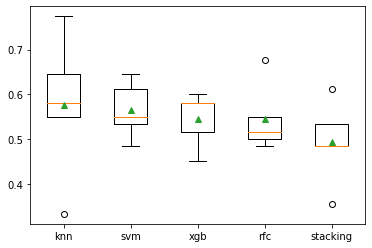

In [32]:
#compare accuracy of stacking model with other standalone models
def evaluate_model2(model, X, y):
    scores = cross_val_score(model, X, y, scoring='accuracy', n_jobs=5, error_score='raise')
    print ('Model score: {}'.format(mean(scores)))
    return scores
results, names = list(), list()
models1 = get_models1()
for name, model in models1.items():
    scores = evaluate_model2(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [33]:
import gc
gc.collect()

10673

In [34]:
#convert labels to float dtype
df['diagnosis']=df['diagnosis'].astype(float)
diagnosis=np.asarray(df['diagnosis'])
X_train,X_test,y_train,y_test= train_test_split(b_r_pca,diagnosis,stratify=diagnosis,test_size=0.4,random_state=42)

In [35]:
!pip install nilearn
!pip install tensorflow --upgrade --force-reinstall --user --use-feature=2020-resolver
!pip install tensorflow-gpu
!conda install keras 
!pip install -q -U keras-tuner
!pip install pydot
!pip install graphviz
import tensorflow as tf
import kerastuner as kt
import IPython
import numpy as np
import joblib
import os
import keras


ow -> jpeg[version='>=9b,<10a']
matplotlib-base -> pillow[version='>=6.2.0'] -> jpeg[version='>=9b,<10a']
qt -> jpeg[version='>=9b,<10a']
bokeh -> pillow[version='>=7.1.0'] -> jpeg[version='>=9b,<10a']
scikit-image -> pillow[version='>=4.3.0'] -> jpeg[version='>=9b,<10a']
anaconda-navigator -> pillow -> jpeg[version='>=9b,<10a']
libtiff -> jpeg[version='>=9b,<10a']
pyqt -> qt=5.9 -> jpeg[version='>=9b,<10a']
anaconda==2020.11 -> jpeg==9b=hb83a4c4_2
imageio -> pillow -> jpeg[version='>=9b,<10a']
anaconda==2020.11 -> libtiff==4.1.0=h56a325e_1 -> jpeg[version='>=9b,<10a']

Package comtypes conflicts for:
xlwings -> comtypes
anaconda==2020.11 -> xlwings==0.20.8=py37_0 -> comtypes
anaconda==2020.11 -> comtypes==1.1.7[build='py38_1001|py37_1001']

Package twisted conflicts for:
prometheus_client -> twisted
notebook -> prometheus_client -> twisted

Package ptyprocess conflicts for:
pexpect -> ptyprocess[version='>=0.5']
spyder -> pexpect[version='>=4.4.0'] -> ptyprocess[version='>=0.5']

Pack

### 7. Prediction with a Keras's sequential model

In [36]:
#build a sequential model with keras
import tensorflow as tf
import pydot
import graphviz
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,TimeDistributed,Dropout,Flatten,Concatenate
from keras.callbacks import TensorBoard
from tensorflow.keras import Input,Model
from kerastuner.engine.hypermodel import HyperModel as hp
from matplotlib import pyplot as plt
import datetime


In [37]:
batch_size=len(X_train)
lr=0.001
momentum=0
epochs=100
#define model
def build_deep_model(lr,momentum):
    deep_model = keras.Sequential([
    keras.Input(shape=(100)),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(2,activation='softmax'),
])
    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,clipnorm=1)
    deep_model.compile(loss='squared_hinge', optimizer=opt, metrics=["accuracy"])
    history=deep_model.fit(X_train, y_train, epochs = epochs, validation_data = (X_test, y_test))
    return deep_model,history
deep_model1=build_deep_model(lr,momentum)

Epoch 1/100
5/5 [==============================] - 2s 252ms/step - loss: 1.4373 - accuracy: 0.5273 - val_loss: 1.4358 - val_accuracy: 0.3942
Epoch 2/100
5/5 [==============================] - 0s 16ms/step - loss: 1.4109 - accuracy: 0.5039 - val_loss: 1.4356 - val_accuracy: 0.3942
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 1.3923 - accuracy: 0.5169 - val_loss: 1.4356 - val_accuracy: 0.3942
Epoch 4/100
5/5 [==============================] - 0s 17ms/step - loss: 1.4100 - accuracy: 0.5152 - val_loss: 1.4354 - val_accuracy: 0.3942
Epoch 5/100
5/5 [==============================] - 0s 17ms/step - loss: 1.4085 - accuracy: 0.4514 - val_loss: 1.4369 - val_accuracy: 0.3846
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 1.4262 - accuracy: 0.4930 - val_loss: 1.4394 - val_accuracy: 0.3846
Epoch 7/100
5/5 [==============================] - 0s 15ms/step - loss: 1.4128 - accuracy: 0.5625 - val_loss: 1.4376 - val_accuracy: 0.3846
Epoch 8/100
5/5 [==

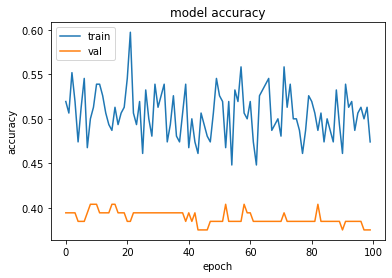

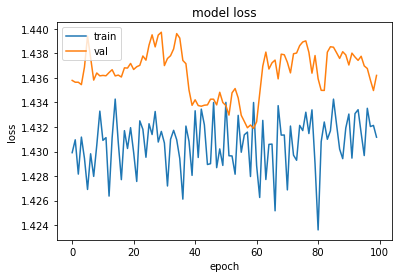

In [38]:
#plot accuracy and loss of model on train and validation sets
plt.plot(deep_model1[1].history['accuracy'])
plt.plot(deep_model1[1].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(deep_model1[1].history['loss'])
plt.plot(deep_model1[1].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
gc.collect()

10621

### 8. Tune model with Keras tuner

In [40]:
import kerastuner as kt

#optimize hyperparameters of model with keras tuner
# define model builder with ranges of hyperparameters
def deep_model_builder(hp):
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    hp_loss=hp.Choice('loss',values=['squared_hinge','sparse_categorical_crossentropy','poisson','kl_divergence'])
    hp_activation=hp.Choice('activation',values=['relu','elu'])
    hp_dropout=hp.Choice('dropout',values=[0.01,0.1,0.2])
    deep_model_hp = keras.Sequential([
    keras.Input(shape=(100)),
    layers.Dense(units=hp_units, activation=hp_activation),
    layers.Dropout(hp_dropout),
    layers.Dense(units=hp_units, activation=hp_activation),
    layers.Dropout(hp_dropout),
    layers.Dense(2,activation='softmax'),
])
    opt_hp=hp.Choice('optimizer',values=['Adam','SGD','Adagrad'])
    deep_model_hp.compile(optimizer = opt_hp,
                loss = hp_loss, 
                metrics = ['accuracy'])
    return deep_model_hp
#define tuner and start search
tuner = kt.Hyperband(deep_model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = epochs,
                     factor = 3,
                     directory = os.path.join('D:\Cache\my_dir_'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
                     project_name = os.path.join('kerastuner_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
tuner.search(X_train, y_train, epochs=epochs, validation_split=0.3)
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]      
print (f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')},optimal loss function is {best_hps.get('loss')}
""")

Trial 254 Complete [00h 00m 06s]
val_accuracy: 0.6382978558540344

Best val_accuracy So Far: 0.6808510422706604
Total elapsed time: 00h 09m 04s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.01,optimal loss function is sparse_categorical_crossentropy



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 480)               48480     
_________________________________________________________________
dropout (Dropout)            (None, 480)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 480)               230880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 480)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 962       
Total params: 280,322
Trainable params: 280,322
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
4/4 [==============================] - 1s 82ms/step - loss: 1031.4535 - accuracy: 0.5196 - val_loss

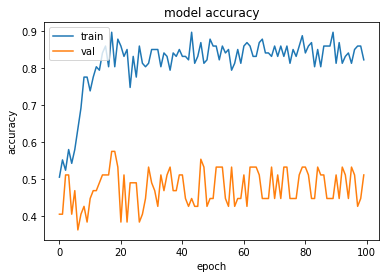

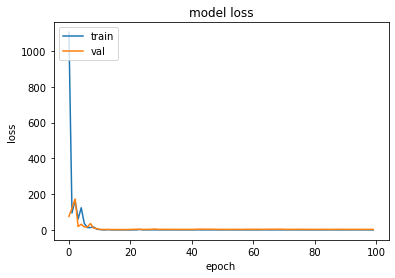

In [45]:

#fit model with best params
best_deep_model = tuner.hypermodel.build(best_hps)
print (best_deep_model.summary())
history_hp=best_deep_model.fit(X_train, y_train, epochs = epochs, validation_split=0.3)
plt.plot(history_hp.history['accuracy'])
plt.plot(history_hp.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history_hp.history['loss'])
plt.plot(history_hp.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
val_acc_per_epoch = history_hp.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 18


In [47]:
#Reinstantiate the hypermodel and train it with the optimal number of epochs from above.
hypermodel = tuner.hypermodel.build(best_hps)
# Retrain the model
final_history=hypermodel.fit(X_test, y_test, epochs=best_epoch)

Epoch 1/18
4/4 [==============================] - 0s 3ms/step - loss: 972.9453 - accuracy: 0.5070
Epoch 2/18
4/4 [==============================] - 0s 3ms/step - loss: 307.4652 - accuracy: 0.4245
Epoch 3/18
4/4 [==============================] - 0s 3ms/step - loss: 136.4369 - accuracy: 0.4204
Epoch 4/18
4/4 [==============================] - 0s 3ms/step - loss: 3.5137 - accuracy: 0.6786
Epoch 5/18
4/4 [==============================] - 0s 3ms/step - loss: 12.3901 - accuracy: 0.5850
Epoch 6/18
4/4 [==============================] - 0s 3ms/step - loss: 2.9350 - accuracy: 0.6518
Epoch 7/18
4/4 [==============================] - 0s 3ms/step - loss: 0.9240 - accuracy: 0.6800
Epoch 8/18
4/4 [==============================] - 0s 3ms/step - loss: 0.6683 - accuracy: 0.6985
Epoch 9/18
4/4 [==============================] - 0s 3ms/step - loss: 1.0949 - accuracy: 0.6836
Epoch 10/18
4/4 [==============================] - 0s 3ms/step - loss: 0.9065 - accuracy: 0.7096
Epoch 11/18
4/4 [===============

In [48]:
#evaluate the hypermodel on the test data
eval_result = hypermodel.evaluate(X_test,y_test)
print("[test loss, test accuracy]:", eval_result)

4/4 [==============================] - 0s 2ms/step - loss: 1.4749 - accuracy: 0.6923
[test loss, test accuracy]: [1.4749367237091064, 0.692307710647583]


In [ ]:
#save model
hypermodel.save('b_r_fmri_20210215.model')

## **4. Conclusion and future directions**

- In this project, I have used fMRI data to try to solve a binary classification problem with machine learning and deep learning models in a very simplilistic way.
- Although the prediction accuracies of these models are not reliable enough to be used for realistic problems, I believe that they can be improved further by combining with more datasets. Furthermore, other fMRI experiments can be incoporated as well, given enough computing power. 
- I hope to rewrite this code for future implementation of keras-gpu.